In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

**Gaussian processes** model a latent function based on a finite set of (noisy) observations of the function: $$ \mathcal{D} = \left\{ \left(x_i,y_i\right)\right\}_{i=1}^n.$$ A key is that our choice of mean and kernel imposes smoothness conditions on the functions. The kernel specifically specifies the correlations of the $y_i$ as a function of the Euclidean distances of the $x_i$. Thus, nearby $x_i$ will have highly-correlated $y_i$.

The Gaussian process prior over the function values is $$ \left. f\left(x\right) \, \middle| \, \theta \right. \sim \text{GP}\left(m_{\theta}\left(x\right), k_{\theta}\left(x,x'\right)\right) $$ which is really a normal distribution. This is called a prior (though it depends on the given data) because it is a distribution over the unknown functions.

Our prior knowledge goes a little bit into our choice of $m_{\theta}$ and $k_{\theta}$. In the Bayesian formulation, we can incorporate more information as a prior over the hyperparameters $\theta$. 

The Gaussian process prior is not a multivariate Gaussian. It has a mean and covariance function. The covariance function is of the form $k\left(x,x'\right)$ where $x$ are the function values and $x'$ are all possible values in the input domain. Thus, the covariance describes the correlation of a point with all other points in the input domain. The input domains are generally infinite, so the Gaussian process prior is effectively an infinite-dimensional Gaussian random variable.

Based on this infinite nature of the Gaussian process prior, we can't simply sample from it to evaluate an entire function $f$. Instead, we restrict ourselves to a finite set of points $X$, often called *test points*. Then we want to find $$ y = f\left(X\right).$$ By the properties of Gaussians, if we marginalize on these test points, we obtain another Gaussian distribution $$ y \sim \mathcal{N}\left(m\left(X\right), k\left(X,X\right)\right) $$


## Look at the prior (no data)

Try to think about what's happening. We have a set of test values $X$ which we want to sample from the prior at. But each values of $f_i$ which we are going to sample depends on all the other test values via the covariance. So nearby points are more highly correlated. I think this is the key: points that are nearby in the domain (i.e., close in the Euclidean distance) will have function values which are close by (i.e., have high covariance). This is where the smoothness comes from.

In the following code, we specify our kernel and set up the test points we want to sample at. We specify the GP prior as the multivariate normal where the mean is all zeros and the covariance is the Gram matrix corresponding to the kernel function evaluated on all pairs of the test points at which we want to evaluate.

In [18]:
from scipy.spatial.distance import cdist
def expquad(x, xp):
    sq_norm = -0.5 * cdist(x, xp, 'sqeuclidean')
    return np.exp(sq_norm)



In [28]:
num_samples = 41 # points in each function (finite set of points)
num_funcs = 5 # number of functions to sample

X = np.expand_dims( np.linspace(-4,4, num_samples), 1)
sigma = expquad(X,X) # kernel on the test points
# sigma = np.zeros(shape=(len(X), len(X)))
# # for j in range(len(X)):
# #     for k in range(len(X)):
# #         sigma[j,k] = np.exp(-0.5 * np.abs(X[j] - X[k]))
# sigma = [np.exp(-np.abs(x - y)) for i,x in enumerate(X) for j,y in enumerate(X)]
# sigma = np.array(sigma).reshape(len(X), len(X))


# sample from the Gaussian prior, at our data points
# take mean = 0
ys = np.random.multivariate_normal(
    mean = np.zeros(num_samples),
    cov = sigma,
    size = num_funcs,
)

In [29]:
sigma.shape

(41, 41)

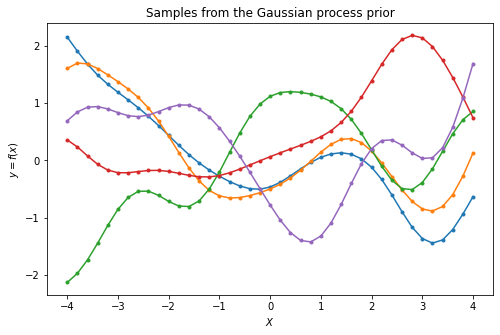

In [30]:
fig, ax = plt.subplots(figsize=(8,5))

for j in range(num_funcs):
    ax.plot(X, ys[j,:], marker = '.')
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y=f\left(x\right)$")
ax.set_title("Samples from the Gaussian process prior")
plt.show()

x_1, x_2, ..., x_n

(f(x_1), ..., f(x_n))

## How to incorporate the data to use for regression?

To do regression, we need to force the functions to interpolate (or nearly interpolate) the given data set. We let the GP prior be defined by a kernel, as usual, and introduce a likelihood function. Assume that we are given dataset $\mathcal{D}=\left\{ \left(X_i, y_i\right)\right\}_{i=1}^n$ and we wish to determine the function values $\hat{y}_j$ at domain points $\hat{X}_j$ for $j=1..m$. Since we assume all function values come from the same function, we have that by our hypothesis they are jointly Gaussian:

$$ \left[ \begin{array}{c} y \\ \hat{y} \end{array} \right] \sim \mathcal{N} \left( \left[ \begin{array}{c} \mu_{y} \\ \mu_{\hat{y}} \end{array} \right],  \left[ \begin{array}{cc} \Sigma_{yy} & \Sigma_{y\hat{y}} \\ \Sigma_{\hat{y}y} & \Sigma_{\hat{y}\hat{y}} \end{array} \right] \right) $$ where the means and covariances are computed from our mean and covariance functions of choice.

By properties of Gaussians, we can obtain the conditional distribution of the unknown values $\hat{y}$ conditioned on the given data $y$; this conditional distribution is also normal and can be shown analytically to be $$ \left. \hat{y} \, \middle| \, y, X, \hat{X} \right. \sim \mathcal{N}\left( \hat{\mu}, \hat{\Sigma} \right) $$ where $$ \hat{\mu} = \mu_{\hat{y}} + \Sigma_{\hat{y}y} \Sigma_{yy}^{-1}\left(y-\mu_y\right) $$ $$ \hat{\Sigma} = \Sigma_{\hat{y}\hat{y}} - \Sigma_{\hat{y}y}\Sigma_{yy}^{-1}\Sigma_{y\hat{y}} $$ Thus, we known exactly the means and the covariances of the multivariate Gaussian distribution that the new function values must follow. Note that the function values are related to the given data through the various components of the original Gram matrix. Specifically, the $\Sigma_{y\hat{y}}$ and $\Sigma_{\hat{y}y}$ blocks --- the ones with mixed indices --- are comprised of elements which hold the kernel values computed between the old points and the new points. These force the new function values, the $\hat{y}$, to be close to the data points if their $\hat{X}$ and $X$ values, respectively, are close (via the kernel).

Note that in both the expression for the mean and the covariance of the $\hat{y}$, we have the matrix inversion and product $\Sigma_{\hat{y}y}\Sigma_{yy}^{-1}$. This is the costly step. We can just go ahead and do the inversion and matrix product, but we can do some linear algebraic tricks to recast the inversion as the solution of a linear system (I don't know that this really saves anything, but it's a neat manipulation). Since we want $\Sigma_{\hat{y}y}\Sigma_{yy}^{-1}$, we will be satisfied with finding its transpose, namely $\left(\Sigma_{\hat{y}y}\Sigma_{yy}^{-1}\right)^T=\Sigma_{yy}^{-1}\Sigma_{y\hat{y}}$. Note the reversal of the indices, which occurs because by the socks-shoes property we must take the transposes of the matrix factors. Now if we let this product (which we want to determine) be equal to some unknown matrix $Z = \Sigma_{yy}^{-1}\Sigma_{y\hat{y}}$, then we have $Z$ as the solution to the linear system $$ \Sigma_{yy}Z = \Sigma_{y\hat{y}} $$ Thus the point of transposition was to move the inverted matrix to the left-hand side of the product so that we could get this nice standard linear system form. Hence we may solve this system for $Z$ using standard methods, transpose $Z$ to obtain the original product we sought, and use it in the expressions for the mean and covariance.

In [31]:
def is_possemidef(A):
    return np.all(np.linalg.eigvals(A) >= 0)

def GP_posterior(X_data, y_data, X_test, mean_func, kernel_func):
    """
        Calculate the mean and covariance tensors for the test function values
            y_test = f(X_test)
        based on the given data (X_data, y_data), the test domain points X_test,
        and the kernel function kernel_func.
    """

    sigma_11 = kernel_func(X_data, X_data)
    sigma_12 = kernel_func(X_data, X_test) # shouldn't matter if kernel is symmetric
    sigma_22 = kernel_func(X_test, X_test)

    # perform the linear algebra to find the product
    zt = np.linalg.solve(sigma_11, sigma_12).T
    
    # compute the conditional dist parameters
    mu = mean_func(X_test) + zt @ (y_data - mean_func(X_data))
    sigma = sigma_22 - zt @ sigma_12

    # if not is_possemidef(sigma):
    #     raise Exception("oops. Covariance matrix is not positive-semidefinite")

    return(mu, sigma)
    



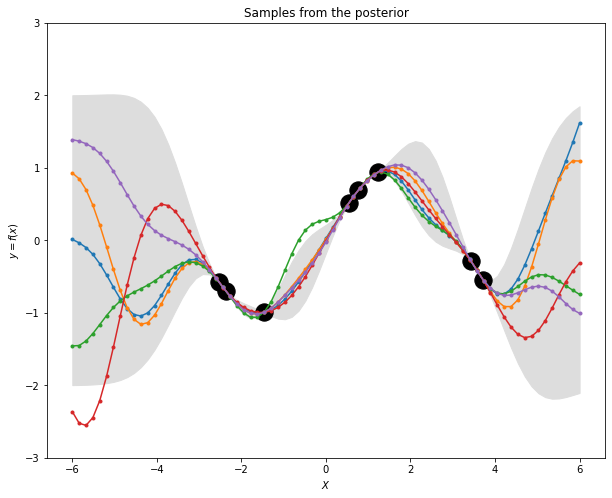

In [32]:
np.random.seed(12345)

func_sin = lambda x: (np.sin(x)).flatten() # true function
domain = (-6,6)

# training set
n_train = 8
X_train = np.random.uniform(domain[0]+2, domain[1]-2, size=(n_train,1))
y_train = func_sin(X_train)

# test set
n_test = 75
X_test = np.linspace(domain[0], domain[1], n_test).reshape(-1,1) # reshape to col vector

# compute the posterior's mean and covariance (conditional of y_test given all the rest)
# computes one set of parameters for each point in the test set
mu_post, sigma_post = GP_posterior(X_train, y_train, X_test, lambda x: 0, expquad)

# get standard deviations at the test points
stdv = np.sqrt(np.diag(sigma_post))

# we can now sample from this posterior to get some possible functions
# treat it as a multivariate Gaussian where each dimension of the Gaussian is one of the 
# domain points
y2 = np.random.multivariate_normal(
    mean = mu_post,
    cov = sigma_post,
    size = 5,
)


fig, ax = plt.subplots(figsize=(10,8))

ax.fill_between(X_test.flatten(), mu_post+2*stdv, mu_post-2*stdv, color="#dddddd")
ax.scatter(X_train, y_train, s=300, marker='o', color="#000000") 
for j in range(num_funcs):
    ax.plot(X_test, y2[j,:], marker = '.')

ax.set_ylim([-3,3])
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y=f\left(x\right)$")
ax.set_title("Samples from the posterior")
plt.show()

## Add noise to our data model

It seems a little strong to expect our functions to exactly interpolate the given data points. That is, we expect that there is some amount of noise in our observations (data). In reality, we often have something like $$ f\left(X\right) = y + \epsilon $$ where we assume $$ \epsilon \sim \mathcal{N}\left(0, \sigma_{\epsilon}^2\right) $$ How does this affect the model that we have in place? It adds a term to the covariance kernel matrix block concerning the training data: $$ \Sigma_{yy} = k\left(X,X\right)+\sigma_{\epsilon}^2 I $$ 

In [33]:
def is_possemidef(A):
    return np.all(np.linalg.eigvals(A) >= 0)

def GP_posterior_noisy(X_data, y_data, X_test, mean_func, kernel_func, sigma_eps):
    """
        Calculate the mean and covariance tensors for the test function values
            y_test = f(X_test)
        based on the given data (X_data, y_data), the test domain points X_test,
        and the kernel function kernel_func.
        The observations are assumed noisy, with noise normally distributed with
        mean zero and variance sigma_eps^2.
    """

    sigma_11 = kernel_func(X_data, X_data) + sigma_eps**2 * np.eye(len(X_data))
    sigma_12 = kernel_func(X_data, X_test) # shouldn't matter if kernel is symmetric
    sigma_22 = kernel_func(X_test, X_test)

    # perform the linear algebra to find the product
    zt = np.linalg.solve(sigma_11, sigma_12).T
    
    # compute the conditional dist parameters
    mu = mean_func(X_test) + zt @ (y_data - mean_func(X_data))
    sigma = sigma_22 - zt @ sigma_12

    # if not is_possemidef(sigma):
    #     raise Exception("oops. Covariance matrix is not positive-semidefinite")

    return(mu, sigma)
    



$$ \theta_{MLE} = \arg\max_{\theta} p\left(y\middle|\theta\right) $$

$$ p\left(y\middle|\theta=2\right) $$

$$\theta_{MAP} = \arg\max_{\theta} p\left(\theta\middle| y\right) $$

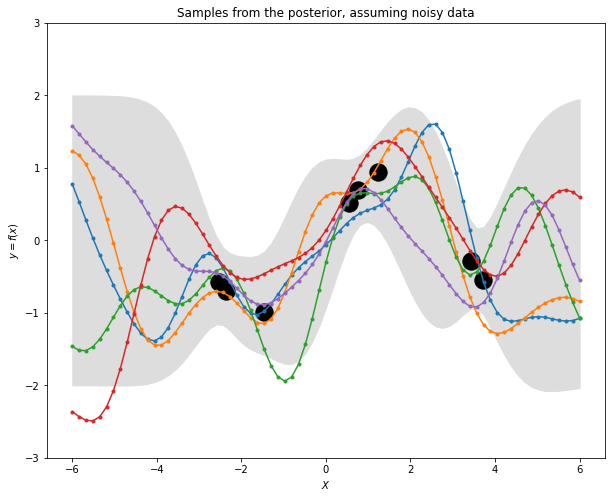

In [34]:
np.random.seed(12345)

func_sin = lambda x: (np.sin(x)).flatten() # true function
domain = (-6,6)

# training set
n_train = 8
X_train = np.random.uniform(domain[0]+2, domain[1]-2, size=(n_train,1))
y_train = func_sin(X_train)
data_noise = 0.4

# test set
n_test = 75
X_test = np.linspace(domain[0], domain[1], n_test).reshape(-1,1) # reshape to col vector

# compute the posterior's mean and covariance (conditional of y_test given all the rest)
# computes one set of parameters for each point in the test set
mu_post, sigma_post = GP_posterior_noisy(X_train, y_train, X_test, lambda x: 0, expquad, data_noise)

# get standard deviations at the test points
stdv = np.sqrt(np.diag(sigma_post))

# we can now sample from this posterior to get some possible functions
# treat it as a multivariate Gaussian where each dimension of the Gaussian is one of the 
# domain points
y2 = np.random.multivariate_normal(
    mean = mu_post,
    cov = sigma_post,
    size = 5,
)


fig, ax = plt.subplots(figsize=(10,8))

ax.fill_between(X_test.flatten(), mu_post+2*stdv, mu_post-2*stdv, color="#dddddd")
ax.scatter(X_train, y_train, s=300, marker='o', color="#000000") 
for j in range(num_funcs):
    ax.plot(X_test, y2[j,:], marker = '.')

ax.set_ylim([-3,3])
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y=f\left(x\right)$")
ax.set_title("Samples from the posterior, assuming noisy data")
plt.show()

## Multiple kernels and hyperparameter tuning

In our kernel functions, we may have parameters representing length scales, spreads, etc. It is a basic component of Bayesian modeling to optimize these parameters, or at least to specify priors over them and compute a posterior. 

Text(0, 0.5, '$CO_2$')

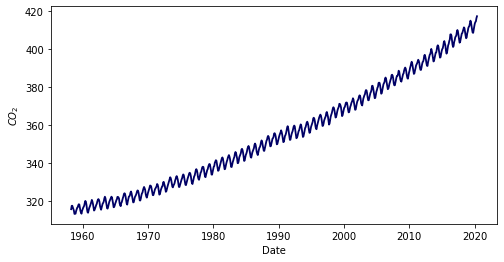

In [35]:
import pandas as pd

df = pd.read_csv("~/Downloads/monthly_in_situ_co2_mlo.csv",
    header = 54, # skip header area
    skiprows = [55,56],  # these are titles for the columns
    usecols = [3, 4], # Date, CO2 columns
    na_values="-99.99",
    dtype = np.float64,
)

df.dropna(inplace=True) # drop NaNs
df.rename(columns=lambda x: x.strip(), inplace=True)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df["Date"], df["CO2"],
    lw=1.8, c="#000066")
ax.set_xlabel("Date")
ax.set_ylabel(r"$CO_2$")

We take all samples pre-2008 as our data and wish to make posterior predictions of the $CO_2$ post-2008. The GP prior is $$ f\left(x\right) \sim \text{GP}\left(m\left(x\right), k\left(x,x'\right)\right) $$ Our modeling choices come in the form of the mean and covariance functions.

For the mean function, we will simply take the mean of the observations, i.e., $m\left(x\right) = \text{const}$.

The kernel function is more complex, and we can combine several contributions to model multiple phenomena. Looking at the data, we observe both long-term increasing trends as well as short term periodicity (seasonality). The long-term trend will be modeled by a exponential quadratic kernel, $$ k\left(x,x'\right) = \sigma^2 \exp \left( -\frac{\left(x-x'\right)^2}{2l^2} \right) $$ where $\sigma$ and $l$ are hyperparameters.

The short-term periodicity will be modeled by, as expected, a periodic function, namely the exponential sine squared kernel, $$ k\left(x,x'\right) = \exp \left( - \frac{2 \sin^2 \left( \frac{\pi}{p} d\left(x,x'\right)\right)}{l^2} \right) $$ where $l$ and $p$ are parameters and $d\left(\cdot, \cdot\right)$ is the Euclidean distance function.

In [36]:
obs_avg = np.average(df["CO2"])
mean_func = lambda x: obs_avg # simple choice

from scipy.spatial.distance import cdist

def kernel_expquad(x, xp, sig, l):
    sq_norm = - cdist(x, xp, 'sqeuclidean') / (2*l**2)
    return sig**2 * np.exp(sq_norm)

def kernel_expsinesq(x, xp, amp, l, p):
    term = np.sin(np.pi * cdist(x, xp, 'euclidean') / p)**2
    return amp * np.exp(-2 * term / (l**2))

First, let's look at samples from the Gaussian process priors with this covariance function.

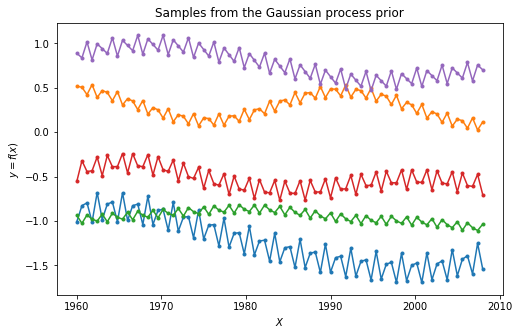

In [39]:
num_samples = 81 # points in each function (finite set of points)
num_funcs = 5 # number of functions to sample

X = np.expand_dims( np.linspace(1960,2008, num_samples), 1) # points to sample at (test points)
# kernel hyperparams - CHANGE THESE AND SEE HOW THINGS VARY
sig_expquad = 0.2
l_expquad = 10
amp_expsinesq = 1
l_expsinesq = 10
p_expsinesq = 1 # CHANGE TO 10 
sigma = kernel_expquad(X,X, sig=sig_expquad, l=l_expquad) + kernel_expsinesq(X,X, amp=amp_expsinesq, l=l_expsinesq, p=p_expsinesq) # kernel on the test points

# sample from this Gaussian prior, at our test points
# take mean = 0
ys = np.random.multivariate_normal(
    mean = np.zeros(num_samples),
    cov = sigma,
    size = num_funcs,
)

fig, ax = plt.subplots(figsize=(8,5))

for j in range(num_funcs):
    ax.plot(X, ys[j,:], marker = '.')
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y=f\left(x\right)$")
ax.set_title("Samples from the Gaussian process prior")
plt.show()

It is important to observe how **our choice of the hyperparameters greatly influences the behaviors of the Gaussian process prior samples**. For instance, changing the $p$ parameter for the periodic covariance term changes the expected periodicity. We know it should be 1 since years have period 1, but if we change it to, e.g., 10, we will see the periodicity of our samples becomes 10 years.

What are we actually doing? If we want to sample (generate a process) from our GP prior, recall that each sample has $N$ dimensions, where $N$ is the number of "test points" which we want observations at. Each observation is a random variable, and they are drawn jointly from the sample multivariate Gaussian, where each component of the Gaussian is one of the dimensions. These components/test points are distinctly **not** independent, since they have covariance specified by our kernel. When we sample from the GP prior, we are really getting a vector of observations, each observation corresponding to one of the dimension of the Gaussian/domain test points, and the observations are all correlated with each other through the covariance matrix. Observations whose x values are close together will have more highly correlated observation values --- this is what the kernel does. This enforces smoothness.

So a single sample from the GP prior gives us a set of observations, where all observations are jointly Gaussian (the same multivariate Gaussian). In the above plot, we took five samples, i.e., we see five sets of observations. The covariance and the means of the GP prior are uniquely determined by our choice of the respective functions and the values of the domain test points $X$ we are looking at, but the stochasticity comes from the fact that we are randomly sampling from the GP prior, which is a prior over the observations.

## What about when data is introduced?

When we have some data, we can fit our GP prior to the data by conditioning on the new observations. That is, we assume the data observations and the new observations are jointly distributed according to the same Gaussian distribution, and if we condition the new observations on the data, then we obtain another Gaussian, whose parameters are analytically determined. Then we end up with a posterior distribution over the new domain test points, conditioned on the old data. We can sample from this posterior to again obtain a sample which is a vector of observations, this time one which conforms to the observed data.

Specifically, when we say that $$ f \sim \text{GP}\left(m\left(x\right),k\left(x,x'\right)\right)$$ what we mean is that for any finite subset of points $\left\{x_i\right\}_{i=1}^n$, we have $$ f\left(x_1\right), f\left(x_2\right), \ldots, f\left(x_n\right) \sim \mathcal{N} \left( \left(m\left(x_1\right),\ldots, m\left(x_n\right)\right), K\left(x_1,\ldots,x_n\right)\right) $$

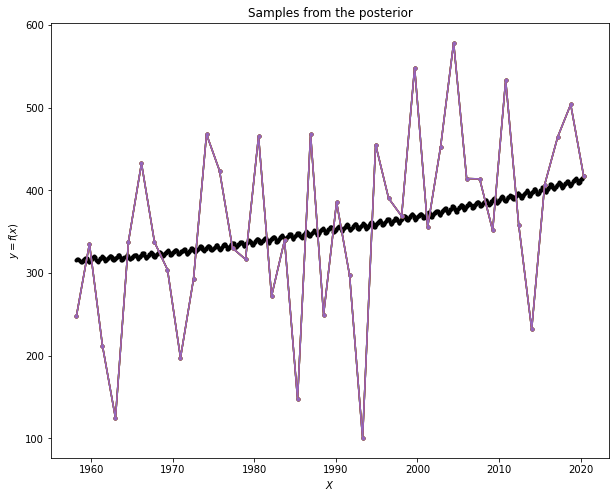

In [40]:
np.random.seed(12345)

domain = (df["Date"].min(),df["Date"].max())

# training set
# mu_x = np.average(df["Date"])
# std_x = np.std(df["Date"])
# mu_y = np.average(df["CO2"])
# std_y = np.std(df["CO2"])
# X_train = ((df["Date"] - mu_x)/std_x).values.reshape(-1,1)
# y_train = ((df["CO2"] - mu_y)/std_y).values.reshape(-1,1)
X_train = df["Date"].values.reshape(-1,1)
y_train = df["CO2"].values.reshape(-1,1)

domain = (X_train.min(),X_train.max())

n_train = len(X_train)
#data_noise = 0.4

# test set
n_test = 40
X_test = np.linspace(domain[0], domain[1], n_test).reshape(-1,1) # reshape to col vector

# compute the posterior's mean and covariance (conditional of y_test given all the rest)
# computes one set of parameters for each point in the test set
def bigkernel(x,xp):
    """ 
        Wrapper for the sum kernels which include hyperparameters.
        Will need to figure out how to train the hyperparams.
    """
    sig_expquad = 94
    l_expquad = 83
    amp_expsinesq = 3.18
    l_expsinesq = 1.59
    p_expsinesq = 0.994
    return kernel_expquad(x,xp, sig=sig_expquad, l=l_expquad) + kernel_expsinesq(x,xp, amp=amp_expsinesq, l=l_expsinesq, p=p_expsinesq) 



mu_post, sigma_post = GP_posterior(X_train, y_train, X_test, 
    mean_func=lambda x: 0, 
    kernel_func=bigkernel,
    )
#mu_post, sigma_post = GP_posterior_noisy(X_train, y_train, X_test, lambda x: 0, expquad, data_noise)

# get standard deviations at the test points
stdv = np.sqrt(np.diag(sigma_post))

# we can now sample from this posterior to get some possible functions
# treat it as a multivariate Gaussian where each dimension of the Gaussian is one of the 
# domain points
y2 = np.random.multivariate_normal(
    mean = mu_post.flatten(),
    cov = sigma_post,
    size = 5,
)


fig, ax = plt.subplots(figsize=(10,8))

ax.fill_between(X_test.flatten(), mu_post.flatten()+2*stdv, mu_post.flatten()-2*stdv, color="#dddddd")
ax.plot(X_train, y_train, lw=.5, marker='.', color="#000000") 
for j in range(num_funcs):
    ax.plot(X_test, y2[j,:], marker = '.')

#x.set_ylim([300,400])
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y=f\left(x\right)$")
ax.set_title("Samples from the posterior")
plt.show()

In [42]:
np.linalg.eigvals(sigma_post)

array([ 1.69844992e-09+0.00000000e+00j, -8.53407327e-10+0.00000000e+00j,
        6.39688387e-10+3.25572057e-10j,  6.39688387e-10-3.25572057e-10j,
       -6.64294590e-10+0.00000000e+00j, -1.41100069e-10+6.58053093e-10j,
       -1.41100069e-10-6.58053093e-10j,  6.07561598e-10+0.00000000e+00j,
       -4.68441582e-10+0.00000000e+00j, -2.88037355e-10+3.14023344e-10j,
       -2.88037355e-10-3.14023344e-10j, -3.68624894e-10+1.79755924e-10j,
       -3.68624894e-10-1.79755924e-10j,  1.97939855e-10+3.88422789e-10j,
        1.97939855e-10-3.88422789e-10j, -2.12203917e-10+3.08781211e-10j,
       -2.12203917e-10-3.08781211e-10j,  3.93262402e-10+0.00000000e+00j,
        1.33916331e-10+3.25520327e-10j,  1.33916331e-10-3.25520327e-10j,
        2.81779407e-10+0.00000000e+00j,  2.48788530e-10+1.04515406e-10j,
        2.48788530e-10-1.04515406e-10j,  2.84647394e-11+2.60673046e-10j,
        2.84647394e-11-2.60673046e-10j,  1.52563956e-10+1.50131768e-10j,
        1.52563956e-10-1.50131768e-10j, -2.04525869

Tune the hyperparameters $\theta$ based on the data. One option is to maximize the marginal likelihood of the Gaussian process distribution based on the observed data: $$ \hat{\theta} = \arg\max_{\theta} p\left(y\, \middle| \, X, \theta \right) $$ But $$ p\left(y \, \middle| \, X,\theta\right) = \frac{1}{\sqrt{ \left(2\pi\right)^d \left|\Sigma_{\theta}\right|} } \exp \left( -\frac{1}{2} \left(y-\mu_{\theta}\right)^T \Sigma_{\theta}^{-1} \left(y-\mu_{\theta}\right)\right)$$ Remove the exponential by looking at the log marginal likelihood $$ \log p\left(y\, \middle| X,\theta \right) = -\frac{1}{2}  \left(y-\mu_{\theta}\right)^T \Sigma_{\theta}^{-1} \left(y-\mu_{\theta}\right) - \frac{1}{2}\log \left| \Sigma_{\theta} \right| - \frac{d}{2}\log 2\pi  $$ Thus we can now determine the optimal parameters for the data by minimizing the negative of the log marginal likelihood: $$ \hat{\theta} = \arg\max_{\theta} p\left(y\, \middle| \, X, \theta\right) = \arg\min_{\theta} -\log p\left(y\, \middle| \, X,\theta \right) $$

In [386]:


theta = [.01,.01,.01,.01]
d = len(X_train) # dims


sigma_theta = kernel_expquad(X_train,X_train, sig=theta[0], l=theta[1]) + kernel_expsinesq(X_train, X_train, l=theta[2], p=theta[3]) 
det = np.linalg.det(sigma_theta)


In [389]:
np.linalg.eigvals(sigma_theta)

array([6.75802237e+00, 6.75796171e+00, 6.75796514e+00, 6.75796513e+00,
       5.94314323e+00, 5.95665571e+00, 5.95703303e+00, 5.57487697e+00,
       5.57487654e+00, 5.58009730e+00, 5.58009643e+00, 5.29440342e+00,
       5.29634187e+00, 5.29620779e+00, 4.70060402e+00, 4.70059637e+00,
       4.70058903e+00, 4.78938463e+00, 4.75749819e+00, 4.83009028e+00,
       5.18966456e+00, 5.10847027e+00, 5.10466958e+00, 4.99631596e+00,
       5.00751408e+00, 4.91741146e+00, 4.91740200e+00, 4.92565587e+00,
       4.87641980e+00, 4.87618865e+00, 4.87618475e+00, 4.74623420e+00,
       4.74622979e+00, 4.74623260e+00, 4.74623150e+00, 5.18387881e+00,
       5.18387394e+00, 5.18386436e+00, 5.18386844e+00, 5.16648762e+00,
       5.16648361e+00, 5.16648443e+00, 5.16648596e+00, 5.04621470e+00,
       5.04613164e+00, 5.04611590e+00, 5.04612636e+00, 5.04612037e+00,
       4.44469774e+00, 4.45781630e+00, 4.41276470e+00, 3.23303886e+00,
       3.24445038e+00, 4.26768797e+00, 4.43428104e+00, 4.43428132e+00,
      

In [17]:
import pymc3 as pm

